In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

## Parameters setup

In [40]:
N = 10

wc = 5.0 * 2 * np.pi #cavity
w1 = 3.0 * 2 * np.pi #qubit 1
w2 = 2.0 * 2 * np.pi #qubit 2

g1 = 0.01 * 2 * np.pi
g2 = 0.0125 * 2 * np.pi

tlist = np.linspace(0, 100, 500)

width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*np.pi)/(4 * g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2*np.pi)/(4 * g2)


# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
n = a.dag() * a

# operators for qubit 1
sm1 = tensor(qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), sigmaz(), qeye(2))
n1 = sm1.dag() * sm1

# oeprators for qubit 2
sm2 = tensor(qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2


# Hamiltonian using QuTiP
Hc = a.dag() * a
H1 = - 0.5 * sz1
H2 = - 0.5 * sz2
Hc1 = g1 * (a.dag() * sm1 + a * sm1.dag())
Hc2 = g2 * (a.dag() * sm2 + a * sm2.dag())

H = wc * Hc + w1 * H1 + w2 * H2 + Hc1 + Hc2

# initial state: start with one of the qubits in its excited state
psi0 = tensor(basis(N,0),basis(2,1),basis(2,0))

## Ideal iSWAP gate

(0.0, 2.0)

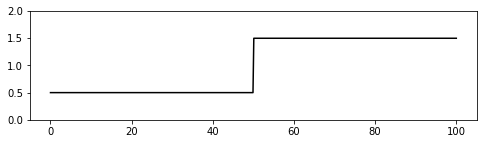

In [43]:

def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t. 
    """
    return w1 + (w2 - w1) * (t > t0)


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50,0, t) for t in tlist], 'k')
axes.set_ylim(0, 2)

In [44]:
def wc_t(t, args=None):
    return wc

def w1_t(t, args=None):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)

def w2_t(t, args=None):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)


H_t = [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2]

res = mesolve(H_t, psi0, tlist, [], [])

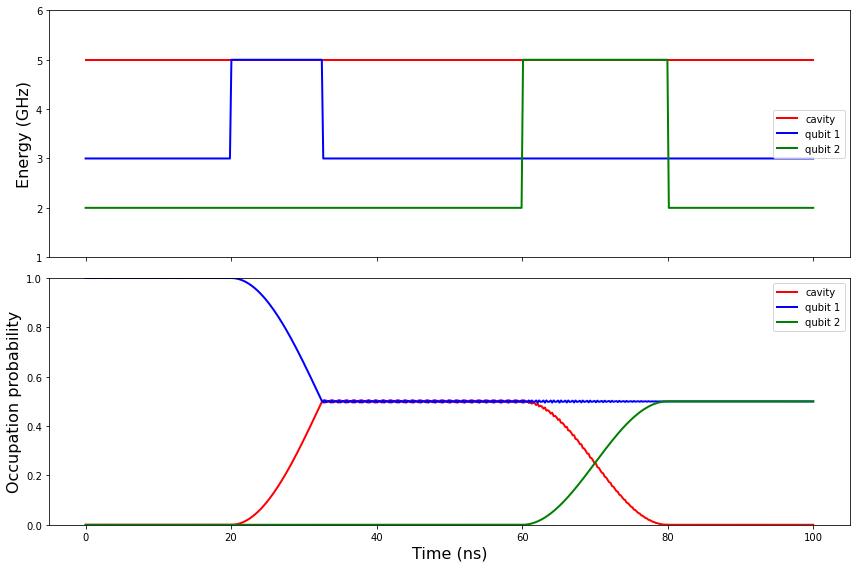

In [45]:

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*np.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*np.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*np.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Inspect the final state

In [46]:
# extract the final state from the result of the simulation
rho_final = res.states[-1]
# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [1,2])
# compare to the ideal result of the sqrtiswap gate (plus phase correction) for the current initial state
from qutip.qip.gates import sqrtiswap 
tqbgate = sqrtswap()
rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(-np.pi/2)) * tqbgate * tensor(basis(2,1), basis(2,0)))
fidelity(rho_qubits, rho_qubits_ideal)

<ipython-input-46-4063182ec315>:7: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  tqbgate = sqrtswap()
<ipython-input-46-4063182ec315>:8: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(-np.pi/2)) * tqbgate * tensor(basis(2,1), basis(2,0)))


0.9997708921798585

In [47]:
concurrence(rho_qubits)

0.9999376168294445

## Dissipative case

In [48]:
kappa = 0.0001
gamma1 = 0.005
gamma2 = 0.005

c_ops = [np.sqrt(kappa) * a, np.sqrt(gamma1) * sm1, np.sqrt(gamma2) * sm2]
res = mesolve(H_t, psi0, tlist, c_ops, e_ops=[])

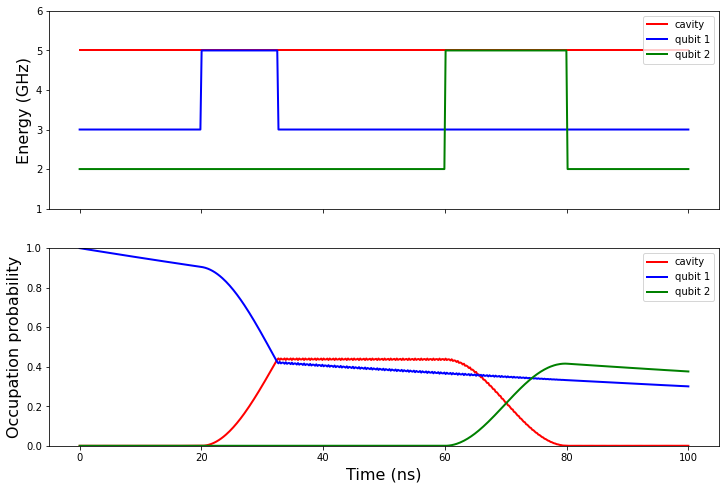

In [51]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*np.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*np.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*np.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

In [53]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])
fidelity(rho_qubits, rho_qubits_ideal)

0.8235715441043868

## Finite pulse rise time


(0.0, 2.0)

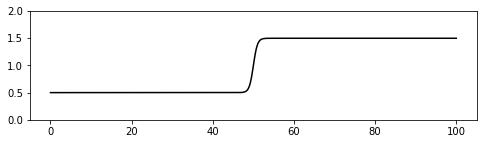

In [58]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t, with finite rise time defined
    by the parameter width.
    """
    return w1 + (w2 - w1) / (1 + np.exp(-(t-t0)/width))

fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, width, t) for t in tlist], 'k')
axes.set_ylim(0, 2)


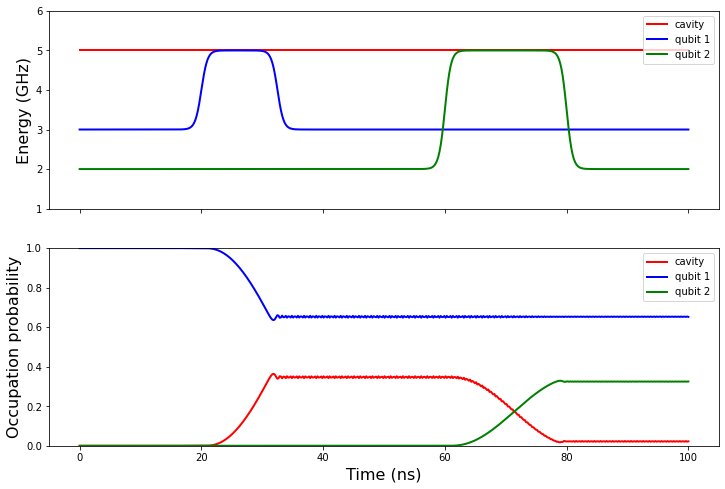

In [59]:
res = mesolve(H_t, psi0, tlist, [], [])
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*np.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*np.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*np.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

In [60]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])
fidelity(rho_qubits, rho_qubits_ideal)

0.9730671549037117

In [61]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.5.2
Numpy,1.19.1
SciPy,1.5.0
matplotlib,3.2.2
Cython,0.29.21
Number of CPUs,8
BLAS Info,INTEL MKL
IPython,7.17.0
Python,"3.8.5 (default, Aug 5 2020, 03:39:04) [Clang 10.0.0 ]"
OS,posix [darwin]


# Single Atom Lasing
$$
\frac{d}{dt}\rho = -i[H, \rho] + \Gamma\left(\sigma+\rho\sigma- - \frac{1}{2}\sigma-\sigma+\rho - \frac{1}{2}\rho\sigma-\sigma+\right)
$$
## Parameters

In [64]:
w0 = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength

kappa = 0.04        # cavity dissipation rate
gamma = 0.00        # atom dissipation rate
Gamma = 0.35        # atom pump rate

N = 50              # number of cavity fock states
n_th_a = 0.0        # avg number of thermal bath excitation

tlist = np.linspace(0, 150, 101)

# intial state
psi0 = tensor(basis(N,0), basis(2,0)) # start without excitations

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))
sx = tensor(qeye(N), sigmax())

# Hamiltonian
H = w0 * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * sx

# collapse operators
c_ops = []

rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a)

rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a.dag())

rate = gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm)

rate = Gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm.dag())

## Evolution and visualization

In [69]:
opt = Odeoptions(nsteps=2000) # allow extra time-steps 
output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm], options = opt)

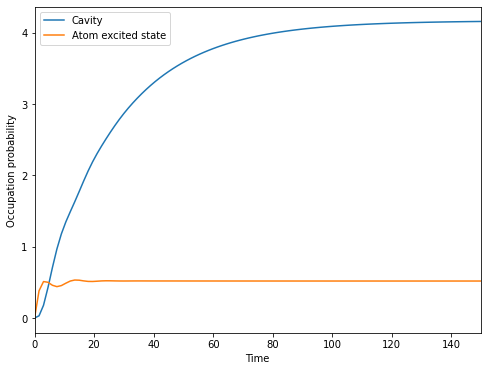

In [70]:
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(8,6))

axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_a, label="Atom excited state")
axes.set_xlim(0, 150)
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability');

## Steady state

Text(0, 0.5, 'Occupation probability')

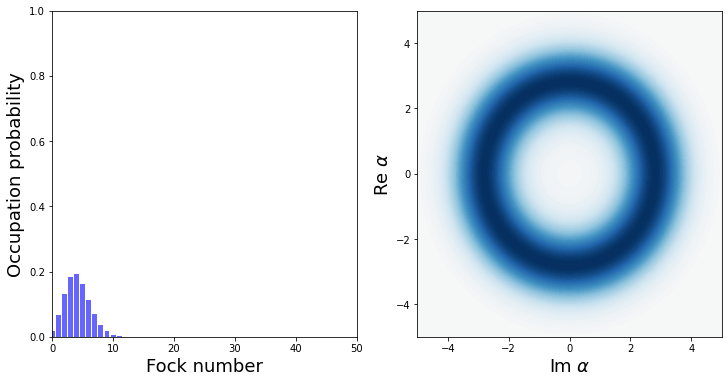

In [76]:
import matplotlib as mpl
rho_ss = steadystate(H, c_ops)
fig, axes = plt.subplots(1, 2, figsize=(12,6))

xvec = np.linspace(-5,5,200)

rho_cavity = ptrace(rho_ss, 0)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()

axes[1].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap='RdBu')
axes[1].set_xlabel(r'Im $\alpha$', fontsize=18)
axes[1].set_ylabel(r'Re $\alpha$', fontsize=18)

axes[0].bar(np.arange(0, N), np.real(rho_cavity.diag()), color="blue", alpha=0.6)
axes[0].set_ylim(0, 1)
axes[0].set_xlim(0, N)
axes[0].set_xlabel('Fock number', fontsize=18)
axes[0].set_ylabel('Occupation probability', fontsize=18)

## Evolution of cavity state

In [78]:
tlist = np.linspace(0, 25, 5)
output = mesolve(H, psi0, tlist, c_ops, [], options=Odeoptions(nsteps=5000))
rho_ss_sublist = output.states

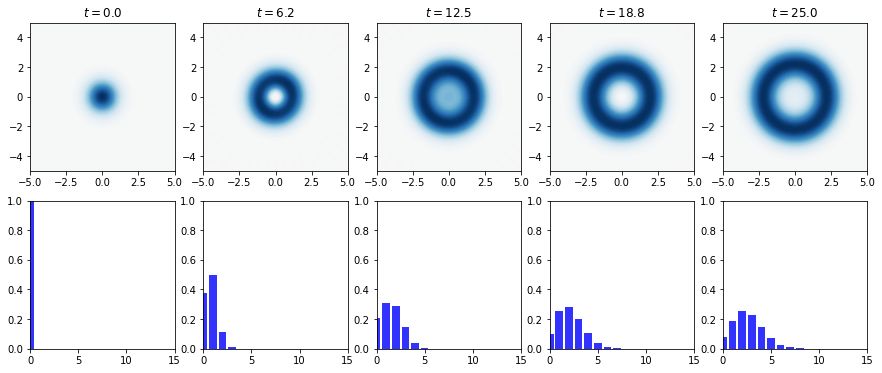

In [81]:
xvec = np.linspace(-5,5,200)

fig, axes = plt.subplots(2, len(rho_ss_sublist), figsize=(3*len(rho_ss_sublist), 6))

for idx, rho_ss in enumerate(rho_ss_sublist):

    # trace out the cavity density matrix
    rho_ss_cavity = ptrace(rho_ss, 0)
    
    # calculate its wigner function
    W = wigner(rho_ss_cavity, xvec, xvec)
    
    # plot its wigner function
    wlim = abs(W).max()
    axes[0,idx].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=plt.get_cmap('RdBu'))
    axes[0,idx].set_title(r'$t = %.1f$' % tlist[idx])
    
    # plot its fock-state distribution
    axes[1,idx].bar(np.arange(0, N), np.real(rho_ss_cavity.diag()), color="blue", alpha=0.8)
    axes[1,idx].set_ylim(0, 1)
    axes[1,idx].set_xlim(0, 15)